Suha Lee <br>
1005155626 <br>
Last Modified: 09-03-2024

**INF2178 Technical Assignment 2 - Code**

The purpose of this assignment is to investigate the availability of child care centres in Toronto.

This report will seek to address to research questions:

**Research Question 1 (RQ1)**: How does the total capacity of child care centres differ among various auspice types in Toronto? <br>
**Research Question 2 (RQ2)**: How do the capacities for different age groups in child care centres vary across auspice types in Toronto, and is there an interaction effect between age group and auspice type on capacity?


##### *Loading and Preprocessing Dataset*

In [485]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
%pip install bioinfokit
from bioinfokit.analys import stat
from statsmodels.graphics.factorplots import interaction_plot

In [486]:
# Set path to dataset file
filepath = '/content/drive/MyDrive/2023 2024 Semester 2/INF2178/A2/INF2178_A2_data.xlsx'

# Load dataset and create dataframe
centre_data = pd.read_excel(filepath)
centre_data.head()

,_id,LOC_ID,LOC_NAME,AUSPICE,ADDRESS,PCODE,ward,bldg_type,BLDGNAME,IGSPACE,TGSPACE,PGSPACE,KGSPACE,SGSPACE,TOTSPACE,subsidy,cwelcc_flag
0,1,1013,Lakeshore Community Child Care Centre,Non Profit Agency,101 SEVENTH ST,M8V 3B5,3,Public Elementary School,Seventh Street Public School,0,20,32,52,60,164,Y,Y
1,2,1014,Alternative Primary School Parent Group,Non Profit Agency,1100 SPADINA RD,M5N 2M6,8,Public Elementary School,North Preparatory Public School,0,0,12,26,45,83,Y,Y
2,3,1015,Cardinal Leger Child Care Centre (Scarborough),Non Profit Agency,600 MORRISH RD,M1C 4Y1,25,Catholic Elementary School,Cardinal Leger Catholic School,0,10,16,26,50,102,Y,Y
3,4,1016,George Brown - Richmond Adelaide Childcare Centre,Non Profit Agency,130 ADELAIDE ST W,M5H 3P5,10,Other,NaN,10,15,40,0,0,65,Y,Y
4,5,1017,Woodland Nursery School (Warden Woods Communit...,Non Profit Agency,1 FIRVALLEY CRT,M1L 1N8,20,High Rise Apartment,NaN,0,10,16,0,0,26,Y,Y


In [487]:
# Display dataframe info
centre_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   _id          1063 non-null   int64 
 1   LOC_ID       1063 non-null   int64 
 2   LOC_NAME     1063 non-null   object
 3   AUSPICE      1063 non-null   object
 4   ADDRESS      1063 non-null   object
 5   PCODE        1063 non-null   object
 6   ward         1063 non-null   int64 
 7   bldg_type    1063 non-null   object
 8   BLDGNAME     715 non-null    object
 9   IGSPACE      1063 non-null   int64 
 10  TGSPACE      1063 non-null   int64 
 11  PGSPACE      1063 non-null   int64 
 12  KGSPACE      1063 non-null   int64 
 13  SGSPACE      1063 non-null   int64 
 14  TOTSPACE     1063 non-null   int64 
 15  subsidy      1063 non-null   object
 16  cwelcc_flag  1063 non-null   object
dtypes: int64(9), object(8)
memory usage: 141.3+ KB


We note that aside from BLDGNAME (which will not be used for this report) there are no null values to be cleaned.

To address our research questions, we focus on columns detailing type of Auspice, Age group, and Capacity.

In [488]:
# Drop unnecessary columns
centre_data = centre_data[['AUSPICE', 'IGSPACE', 'TGSPACE', 'PGSPACE', 'KGSPACE', 'SGSPACE', 'TOTSPACE']]

# Rename variables
centre_data.rename(columns={'AUSPICE': 'Auspice',
                            'IGSPACE': 'Infant',
                            'TGSPACE': 'Toddler',
                            'PGSPACE': 'Preschool',
                            'KGSPACE': 'Kindergarten',
                            'SGSPACE': 'School',
                            'TOTSPACE': 'Total'}, inplace=True)
centre_data.replace({'Public (City Operated) Agency': 'Public Agency'}, inplace=True)

# Display cleaned dataframe
centre_data.head()

,Auspice,Infant,Toddler,Preschool,Kindergarten,School,Total
0,Non Profit Agency,0,20,32,52,60,164
1,Non Profit Agency,0,0,12,26,45,83
2,Non Profit Agency,0,10,16,26,50,102
3,Non Profit Agency,10,15,40,0,0,65
4,Non Profit Agency,0,10,16,0,0,26


##### *Exploratory Data Analysis*

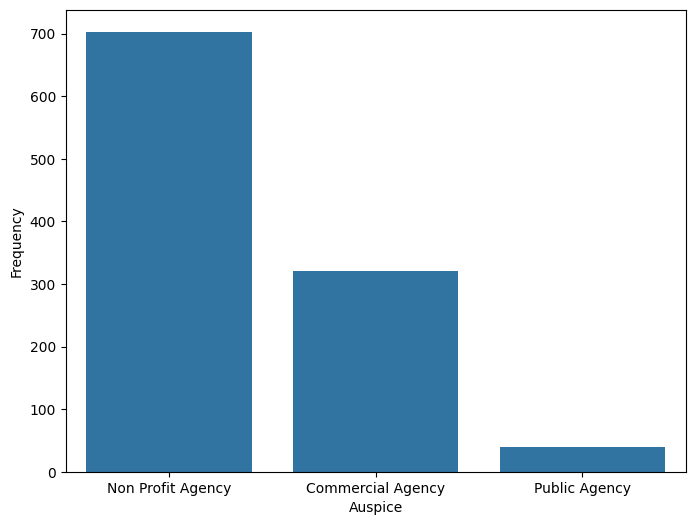

In [489]:
# Get freuquency counts for Auspice
auspice_counts = centre_data['Auspice'].value_counts().reset_index()
auspice_counts.columns = ['Auspice', 'Frequency']

# Display bargraph of Auspice frequencies
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Auspice', y='Frequency', data=auspice_counts)
plt.show()

The dataset covers three different auspices, with the majority of the listed services being run by non-profit agencies. Government-run services are an extremely small minority, perhaps highlighting one aspect we can address to further supply.

In [490]:
# Display descriptive statistics for capacity variables
centre_data.describe()

,Infant,Toddler,Preschool,Kindergarten,School,Total
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,3.896519,11.600188,24.258702,14.257761,21.661336,75.674506
std,6.091782,12.088152,18.577416,20.493290,30.423503,47.816518
min,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,0.000000,0.000000,16.000000,0.000000,0.000000,43.000000
50%,0.000000,10.000000,24.000000,0.000000,0.000000,62.000000
75%,10.000000,15.000000,32.000000,26.000000,30.000000,97.000000
max,30.000000,90.000000,144.000000,130.000000,285.000000,402.000000


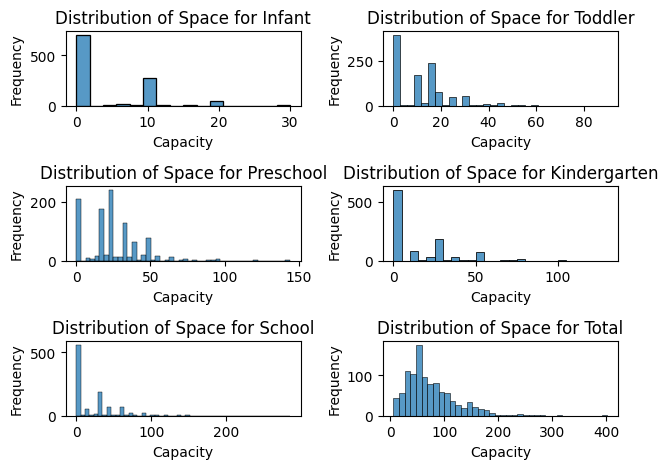

In [491]:
# Plot histogram for each capacity variable
fig, ax = plt.subplots(nrows=3, ncols=2)
ax = ax.flatten()
capacity_vars = centre_data[['Infant', 'Toddler', 'Preschool', 'Kindergarten', 'School', 'Total']]
for i, col in enumerate(capacity_vars):
    sns.histplot(data=capacity_vars, x=col, ax=ax[i], edgecolor='black')
    ax[i].set_title(f'Distribution of Space for {col}')
    ax[i].set_xlabel('Capacity')
    ax[i].set_ylabel('Frequency')

# Display plot
plt.tight_layout()
plt.show()

For each of the age groups, there are a significant number of zero capacities reported. This indicates that most services focus on a subset of age groups to cater to, rather than serving them all. We can further investigate which groups are least serviced and are in need of more spaces.

##### *One-way ANOVA*

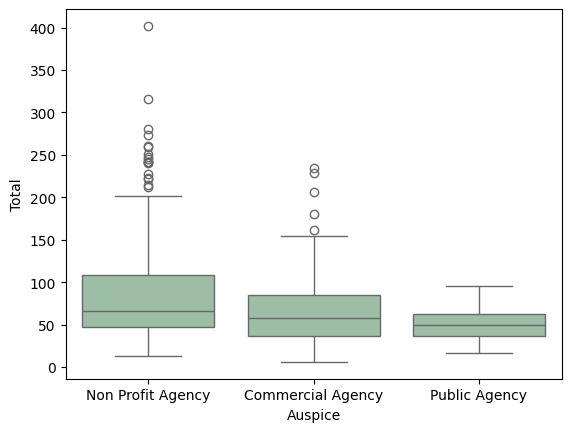

In [492]:
# Display boxplots for Total capacities by Auspice
ax = sns.boxplot(x='Auspice', y='Total', data=centre_data, color='#99c2a2')
plt.show()

The variances appear to differ greatly, perhaps simply due to the skew in distribution.

In [493]:
# Perform one-way ANOVA on Total capacity by Auspice
res = stat()
res.anova_stat(df=centre_data, res_var='Total', anova_model='Total ~ C(Auspice)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(Auspice),2.0,9.611211e+04,48056.057145,21.843051,5.057716e-10
Residual,1060.0,2.332065e+06,2200.061571,NaN,NaN


For alpha=0.05, we have a significant difference based on Auspice type.

In [494]:
# Perform post hoc tests using Tukey
res = stat()
res.tukey_hsd(df=centre_data, res_var='Total', xfac_var='Auspice', anova_model='Total ~ C(Auspice)')
res.tukey_summary

/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to 

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Non Profit Agency,Commercial Agency,17.119417,9.703599,24.535235,7.662434,0.001000
1,Non Profit Agency,Public Agency,34.334610,16.224077,52.445142,6.292710,0.001000
2,Commercial Agency,Public Agency,17.215193,-1.453146,35.883531,3.060857,0.077966


Post-hoc tests show that non-profit agencies have significantly higher capacities than the others, while there is no significant difference between commercial and government-run programs.

Testing Assumptions

*Assumption 1: Residuals are normally distributed*

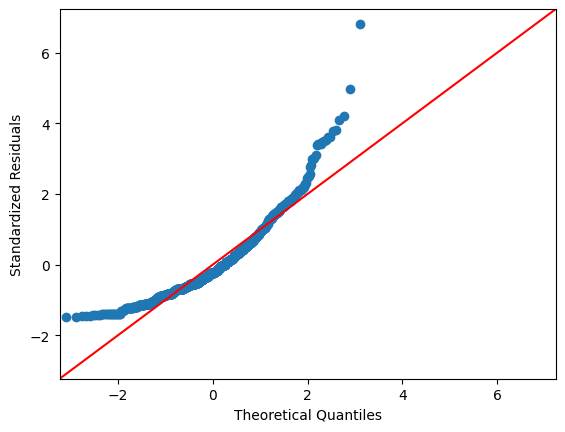

In [495]:
# Plot standardized residuals obtained from ANOVA
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

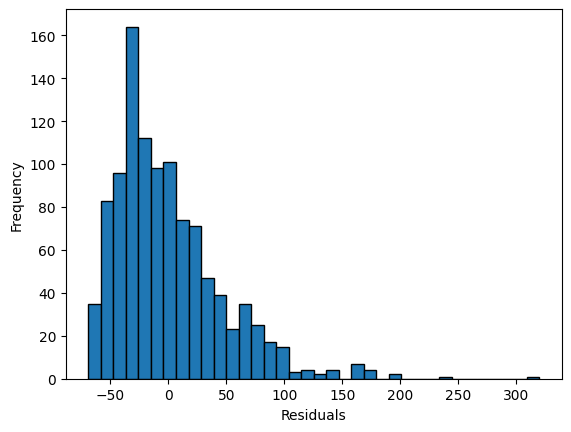

In [496]:
# Plot histogram of residuals
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k')
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [497]:
def shapiro_wilk(relation, data, alpha=0.05):
  """
  Performs the Shapiro-Wil Test for normality based on a given relations ANOVA
  residuals.

  Args:
    relation: a string representing the relation for the model
    data: a dataframe representing the data
    alpha: a float representing the threshold for significance (default=0.05)
  Returns:
    None
  """

  # Create model
  model = ols(relation, data=data).fit()

  # Perform Shapiro-Wilk Test
  w, pvalue = stats.shapiro(model.resid)

  # Print results of test
  print(f'Test statistic (W): {w}\np-value: {pvalue}\n')
  if pvalue < alpha:
    print('The residuals are not normally distributed')
  else:
    print('The residuals are normally distributed')

In [498]:
# Perform Shapiro-Wilk test
relation = 'Total ~ C(Auspice)'
shapiro_wilk(relation, centre_data)

Test statistic (W): 0.901775598526001
p-value: 1.4964898448030214e-25

The residuals are not normally distributed


*Assumption 2: Variances are homogenous*

The Levene test is utilized as it is more robust to departures from normality than the Bartlett test

In [499]:
# Perform Levene test
res = stat()
res.levene(df=centre_data, res_var='Total', xfac_var='Auspice')
res.levene_summary

,Parameter,Value
0,Test statistics (W),17.9271
1,Degrees of freedom (Df),2.0000
2,p value,0.0000


Both tests failed, indicating that ANOVA is not appropriate.

##### *Two-way ANOVA*

In [500]:
# Collapse age group columns as single categorical variable
auspice_age_melt = pd.melt(centre_data, id_vars=['Auspice'],
                           value_vars=['Infant', 'Toddler',	'Preschool',	'Kindergarten',	'School'],
                           var_name='Age', value_name='Capacity')
auspice_age_melt.head()

,Auspice,Age,Capacity
0,Non Profit Agency,Infant,0
1,Non Profit Agency,Infant,0
2,Non Profit Agency,Infant,0
3,Non Profit Agency,Infant,10
4,Non Profit Agency,Infant,0


<Axes: xlabel='Age', ylabel='Capacity'>

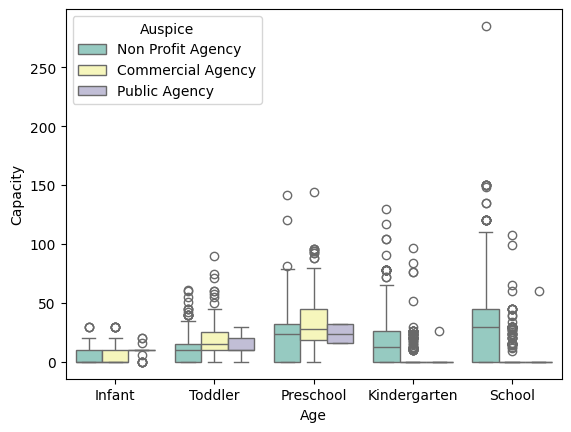

In [501]:
# Display boxplots for Capacity by Auspice and Age
sns.boxplot(x="Age", y="Capacity", hue="Auspice",data=auspice_age_melt, palette="Set3")

We see that commercial and government agencies appear to be most active in the toddler and preschool levels, while non-profits cover most of the needs for kindergarten and school aged children.

In [502]:
# Perform two-way ANOVA on Capacity by Auspice and Age
res = stat()
res.anova_stat(df=auspice_age_melt, res_var='Capacity', anova_model='Capacity ~ C(Age) + C(Auspice) + C(Age):C(Auspice)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(Age),4.0,2.821233e+05,70530.816839,213.579208,3.726614e-170
C(Auspice),2.0,1.922242e+04,9611.211429,29.104369,2.685589e-13
C(Age):C(Auspice),8.0,2.206458e+05,27580.726915,83.519093,9.972931e-131
Residual,5300.0,1.750233e+06,330.232598,NaN,NaN


We observe signficant differences based on auspice and age, including the interaction between them.

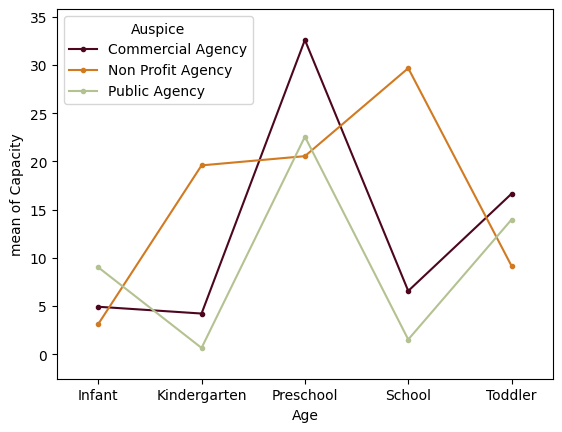

In [503]:
# Display interaction plot for effects of Auspice and Age on Capacity
fig = interaction_plot(x=auspice_age_melt['Age'],trace=auspice_age_melt['Auspice'],response=auspice_age_melt['Capacity'],colors=['#4c061d','#d17a22','#b4c292'])
plt.show()

Commercial and public agencies have very similar trends, peaking at preschool (and toddler) while remaining low and flat at infant, kindergarten, and school. In contrast, non-profits mostly address older children, from preschool and up, while having lower mean capacities for infants and toddlers. The difference in trends indicates interactions of interest between Age and Auspice.

In [504]:
# Perform post hoc tests for Age using Tukey
res.tukey_hsd(df=auspice_age_melt, res_var='Capacity',xfac_var='Age',anova_model='Capacity ~ C(Age) + C(Auspice) + C(Age):C(Auspice)')
res.tukey_summary

/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to 

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Infant,Toddler,7.703669,5.552803,9.854535,13.821471,0.001000
1,Infant,Preschool,20.362183,18.211316,22.513049,36.532634,0.001000
2,Infant,Kindergarten,10.361242,8.210376,12.512108,18.589533,0.001000
3,Infant,School,17.764817,15.613951,19.915683,31.872592,0.001000
4,Toddler,Preschool,12.658514,10.507648,14.809380,22.711163,0.001000
5,Toddler,Kindergarten,2.657573,0.506707,4.808439,4.768062,0.006750
6,Toddler,School,10.061148,7.910282,12.212014,18.051121,0.001000
7,Preschool,Kindergarten,10.000941,7.850075,12.151807,17.943102,0.001000
8,Preschool,School,2.597366,0.446500,4.748232,4.660042,0.008773
9,Kindergarten,School,7.403575,5.252709,9.554441,13.283060,0.001000


In [505]:
# Perform post hoc tests for Auspice using Tukey
res.tukey_hsd(df=auspice_age_melt, res_var='Capacity',xfac_var='Auspice',anova_model='Capacity ~ C(Age) + C(Auspice) + C(Age):C(Auspice)')
res.tukey_summary

/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to 

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Non Profit Agency,Commercial Agency,3.423883,2.140456,4.707311,8.844824,0.001000
1,Non Profit Agency,Public Agency,6.866922,3.732600,10.001244,7.263738,0.001000
2,Commercial Agency,Public Agency,3.443039,0.212180,6.673898,3.533178,0.033472


The post-hoc tests indicate signifciant differences for capacity based on every pair of auspice as well as age. Interestingly, we now see a statistically significant different between commercial and public agencies. This may be attributed to the interaction between them.

Testing Assumptions

*Assumption 1: Residuals are normally distributed*

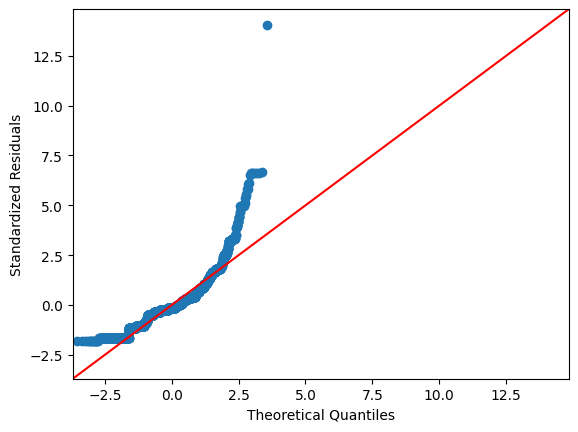

In [506]:
# Plot standardized residuals obtained from ANOVA
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

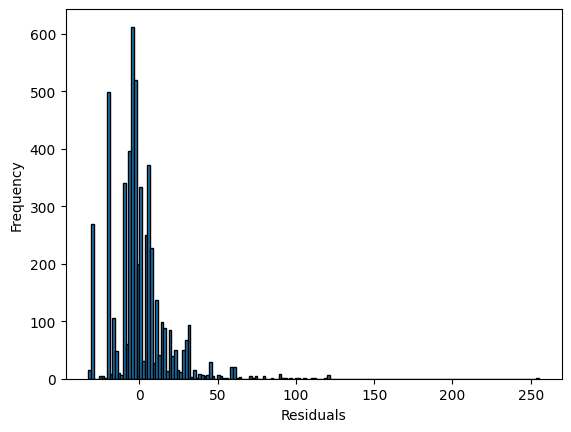

In [507]:
# Plot histogram of residuals
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k')
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [508]:
# Perform Shapiro-Wilk test
relation = 'Capacity ~ C(Age) + C(Auspice) + C(Age):C(Auspice)'
shapiro_wilk(relation, auspice_age_melt)

Test statistic (W): 0.8596770763397217
p-value: 0.0

The residuals are not normally distributed


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


*Assumption 2: Variances are homogenous*

The Levene test is utilized as it is more robust to departures from normality than the Bartlett test

In [509]:
# Perform Levene test
res = stat()
res.levene(df=auspice_age_melt, res_var='Capacity', xfac_var=['Auspice', 'Age'])
res.levene_summary

,Parameter,Value
0,Test statistics (W),114.0
1,Degrees of freedom (Df),14.0
2,p value,0.0


Both tests failed, indicating that ANOVA is not appropriate.